# Hartree Fock Implementation

In [1]:
import numpy as np
from numpy import linalg as la
from scipy import integrate
from scipy.special import erf
from matplotlib import pyplot as plt
plt.style.use('seaborn')

In [2]:
class hf_integrals:
    def __init__(self, basis_coeffs):
        self.basis_coeffs = basis_coeffs

    def overlap_primitive(self, R_A, alpha_1, R_B, alpha_2): 
        factor_1 = (np.pi/(alpha_1 + alpha_2))**(3/2)
        factor_2 = np.exp(-alpha_1*alpha_2/(alpha_1 + alpha_2)*la.norm(R_A - R_B)**2)
        factor_3 = (2*alpha_1/np.pi)**(3/4)
        factor_4 = (2*alpha_2/np.pi)**(3/4)
        return factor_1*factor_2*factor_3*factor_4

    def overlap(self, R_A, R_B):
        S = []
        for center_1 in [R_A, R_B]:
            for center_2 in [R_A, R_B]:
                integral = 0
                for gaussian_1 in self.basis_coeffs:
                    for gaussian_2 in self.basis_coeffs:
                        integral += gaussian_1[0]*gaussian_2[0]* \
                            self.overlap_primitive(center_1, gaussian_1[1], center_2, gaussian_2[1])
                S.append(integral)
        S = np.array(S).reshape(2, 2)
        return S

    def F0(self, t):
        if t != 0:
            return 1/2*(np.pi/t)**(1/2)*erf(t**(1/2))
        else: 
            return 1

    def kinetic_primitive(self, R_A, alpha_1, R_B, alpha_2):
        norm_sq = la.norm(R_A - R_B)**2
        factor_1 = alpha_1*alpha_2/(alpha_1 + alpha_2)
        factor_2 = (3 - 2*factor_1*norm_sq)
        factor_3 = (np.pi/(alpha_1 + alpha_2))**(3/2)
        factor_4 = np.exp(-factor_1*norm_sq)
        factor_5 = (2*alpha_1/np.pi)**(3/4)
        factor_6 = (2*alpha_2/np.pi)**(3/4)
        return factor_1*factor_2*factor_3*factor_4*factor_5*factor_6

    def nuclear_attraction_primitive(self, R_A, alpha_1, R_B, alpha_2, R_C):
        Z_C=1 #charge for hydrogen nucleus
        R_P = (alpha_1*R_A + alpha_2*R_B)/(alpha_1 + alpha_2)
        factor_1 = -2*np.pi*Z_C/(alpha_1 + alpha_2)
        factor_2 = np.exp(-alpha_1*alpha_2/(alpha_1 + alpha_2)*la.norm(R_A - R_B)**2)
        factor_3 = self.F0((alpha_1 + alpha_2)*la.norm(R_P - R_C)**2)
        factor_4 = (2*alpha_1/np.pi)**(3/4)
        factor_5 = (2*alpha_2/np.pi)**(3/4)
        return factor_1*factor_2*factor_3*factor_4*factor_5

    def core_hamiltonian(self, R_A, R_B):
        # kinetic energy calculations
        T = []
        for center_1 in [R_A, R_B]:
            for center_2 in [R_A, R_B]:
                integral = 0
                for gaussian_1 in self.basis_coeffs:
                    for gaussian_2 in self.basis_coeffs:
                        integral += gaussian_1[0]*gaussian_2[0]* \
                            self.kinetic_primitive(center_1, gaussian_1[1], center_2, gaussian_2[1])
                T.append(integral)
        T = np.array(T).reshape(2, 2)

        # nuclear attraction calculations
        V1 = []
        V2 = []
        for center_1 in [R_A, R_B]:
            for center_2 in [R_A, R_B]:
                integral_1 = 0
                integral_2 = 0 
                for gaussian_1 in self.basis_coeffs:
                    for gaussian_2 in self.basis_coeffs:
                        integral_1 += gaussian_1[0]*gaussian_2[0]* \
                            self.nuclear_attraction_primitive(center_1, gaussian_1[1], center_2, gaussian_2[1], R_A)
                        integral_2 += gaussian_1[0]*gaussian_2[0]* \
                            self.nuclear_attraction_primitive(center_1, gaussian_1[1], center_2, gaussian_2[1], R_B)
                V1.append(integral_1)
                V2.append(integral_2)
        V1 = np.array(V1).reshape(2, 2)
        V2 = np.array(V2).reshape(2, 2)

        # now put together the core-Hamiltonian matrix
        H_core = T + V1 + V2 
        return H_core

    def two_electron_primitive(self, R_A, alpha_1, R_B, alpha_2, R_C, alpha_3, R_D, alpha_4):
        R_P = (alpha_1*R_A + alpha_2*R_B)/(alpha_1 + alpha_2)
        R_Q = (alpha_3*R_C + alpha_4*R_D)/(alpha_3 + alpha_4)
        norm_sq1 = la.norm(R_A - R_B)**2
        norm_sq2 = la.norm(R_C - R_D)**2
        norm_sq3 = la.norm(R_P - R_Q)**2
        factor_1 = 2*np.pi**(5/2)/((alpha_1 + alpha_2)*(alpha_3 + alpha_4)*np.sqrt(alpha_1 + alpha_2 + alpha_3 + alpha_4))
        factor_2 = np.exp(-alpha_1*alpha_2/(alpha_1 + alpha_2)*norm_sq1)
        factor_3 = np.exp(-alpha_3*alpha_4/(alpha_3 + alpha_4)*norm_sq2)
        factor_4 = self.F0((alpha_1 + alpha_2)*(alpha_3 + alpha_4)/(alpha_1 + alpha_2 + alpha_3 + alpha_4)*norm_sq3)
        factor_5 = (2*alpha_1/np.pi)**(3/4)
        factor_6 = (2*alpha_2/np.pi)**(3/4)
        factor_7 = (2*alpha_3/np.pi)**(3/4)
        factor_8 = (2*alpha_4/np.pi)**(3/4)
        return factor_1*factor_2*factor_3*factor_4*factor_5*factor_6*factor_7*factor_8
        
    def two_electron(self, R_A, R_B, R_C, R_D):
        integral = 0
        for gaussian_1 in self.basis_coeffs:
            for gaussian_2 in self.basis_coeffs:
                for gaussian_3 in self.basis_coeffs:
                    for gaussian_4 in self.basis_coeffs:
                        integral += gaussian_1[0]*gaussian_2[0]*gaussian_3[0]*gaussian_4[0]* \
                            self.two_electron_primitive(R_A, gaussian_1[1], R_B, gaussian_2[1], \
                                R_C, gaussian_3[1], R_D, gaussian_4[1])
        return integral

In [3]:
class hf_solver:
    def __init__(self, basis_coeffs):
        self.basis_coeffs = basis_coeffs

    def compute_integrals(self, R_A, R_B):
        self.internuclear_dist = la.norm(R_A - R_B)
        integrator = hf_integrals(self.basis_coeffs)
        self.S = integrator.overlap(R_A, R_B)
        self.H_core = integrator.core_hamiltonian(R_A, R_B)
        two_electron_vals = dict()
        index_map = {'1':R_A, '2':R_B}
        for i1 in ['1', '2']:
            for i2 in ['1', '2']:
                for i3 in ['1', '2']:
                    for i4 in ['1', '2']:
                        two_electron_vals[i1 + i2 + i3 + i4] = \
                            integrator.two_electron(index_map[i1], index_map[i2], index_map[i3], index_map[i4])
        self.two_electron_vals = two_electron_vals

    def SCF(self, P0=None, tol=1e-10, maxiter=None):
        """
            Function to carry out Hartree-Fock in the two nucleus, two electron case for hydrogen.

            Parameters:
                tol (float): convegence criterion
                maxiter(int): maximum number of iterations (optional)
        """
        # diagonalize S and use it to get X (step 3 in szabo-ostlund pg 271)
        s, U = la.eig(self.S)
        X = U@np.diag(1/np.sqrt(s))@np.conjugate(U).T

        # guess an initial density matrix P and start iterating (step 4)
        if P0 is None: P0 = np.zeros((2, 2))
        counter = 0 #count iterations in case we want to cap them
        while True:
            # construct the Fock matrix F (steps 5 and 6)
            F = np.zeros((2, 2))
            for mu in range(1, 3):
                for nu in range(1, 3):
                    term = 0
                    term2 = 0
                    for lam in range(1, 3):
                        for sig in range(1, 3):
                            P_term = P0[lam - 1, sig - 1]
                            term += P_term*(self.two_electron_vals[str(mu) + str(nu) + str(sig) + str(lam)] \
                                - 1/2*self.two_electron_vals[str(mu) + str(lam) + str(sig) + str(nu)])
                    F[mu - 1, nu - 1] = self.H_core.copy()[mu - 1, nu - 1] + term
           
            # transform the Fock matrix and diagonalize (steps 7 and 8)
            F_p = X.T@F@X 
            eps, C_p = la.eig(F_p)
            if eps[0] < eps[1]:
                eps = eps[::-1]
                C_p = np.concatenate((C_p[:, 1], C_p[:, 0])).reshape(2, 2)
            
            # calculate C using the C_p we got above (step 9)
            C = X@C_p

            # form a new density matrix P from C (step 10)
            P = np.ones((2, 2))
            for i in range(2):
                for j in range(2):
                    P[i, j] = 2*C[i, 1]*C[j, 1]

            # check convergence (step 11)
            std_dev = 0
            for i in range(2):
                for j in range(2):
                    std_dev += (P[i, j] - P0[i, j])**2
            if np.sqrt(std_dev) < 1e-4:
                break

            # optional iteration cap (defaults to no cap)
            if maxiter is not None and counter >= maxiter:
                raise Exception('Did not converge within maxiter iterations.')
            
            # set P0 = P for the next iteration, increment counter
            P0 = P
            counter += 1

        self.X = X
        self.P = P
        self.F = F 
        self.C = C
        self.eps = eps
        
    def compute_energy(self):
        energy = 0
        for i in range(2):
            for j in range(2):
                energy += self.P[j, i]*(self.H_core[i, j] + self.F[i, j])
        energy /= 2
        repulsion = 1/self.internuclear_dist
        return energy + repulsion

In [4]:
basis_coeffs = [(.4446345422, .1688554040), (.5353281423, .6239137298), (.1543289673, 3.425250914)]
hf = hf_solver(basis_coeffs)

# R_A = np.array([0, 0, 0])
# R_B = np.array([1.36, 0, 0])
# hf.compute_integrals(R_A, R_B)
# hf.SCF()
# hf.compute_energy()

distances = []
energy_vals = []
for x in np.linspace(.5, 6, 100):
    R_A = np.array([0, 0, 0])
    R_B = np.array([x, 0, 0])
    distances.append(la.norm(R_A - R_B))
    hf.compute_integrals(R_A, R_B)
    hf.SCF(maxiter=10000)
    energy_vals.append(hf.compute_energy())

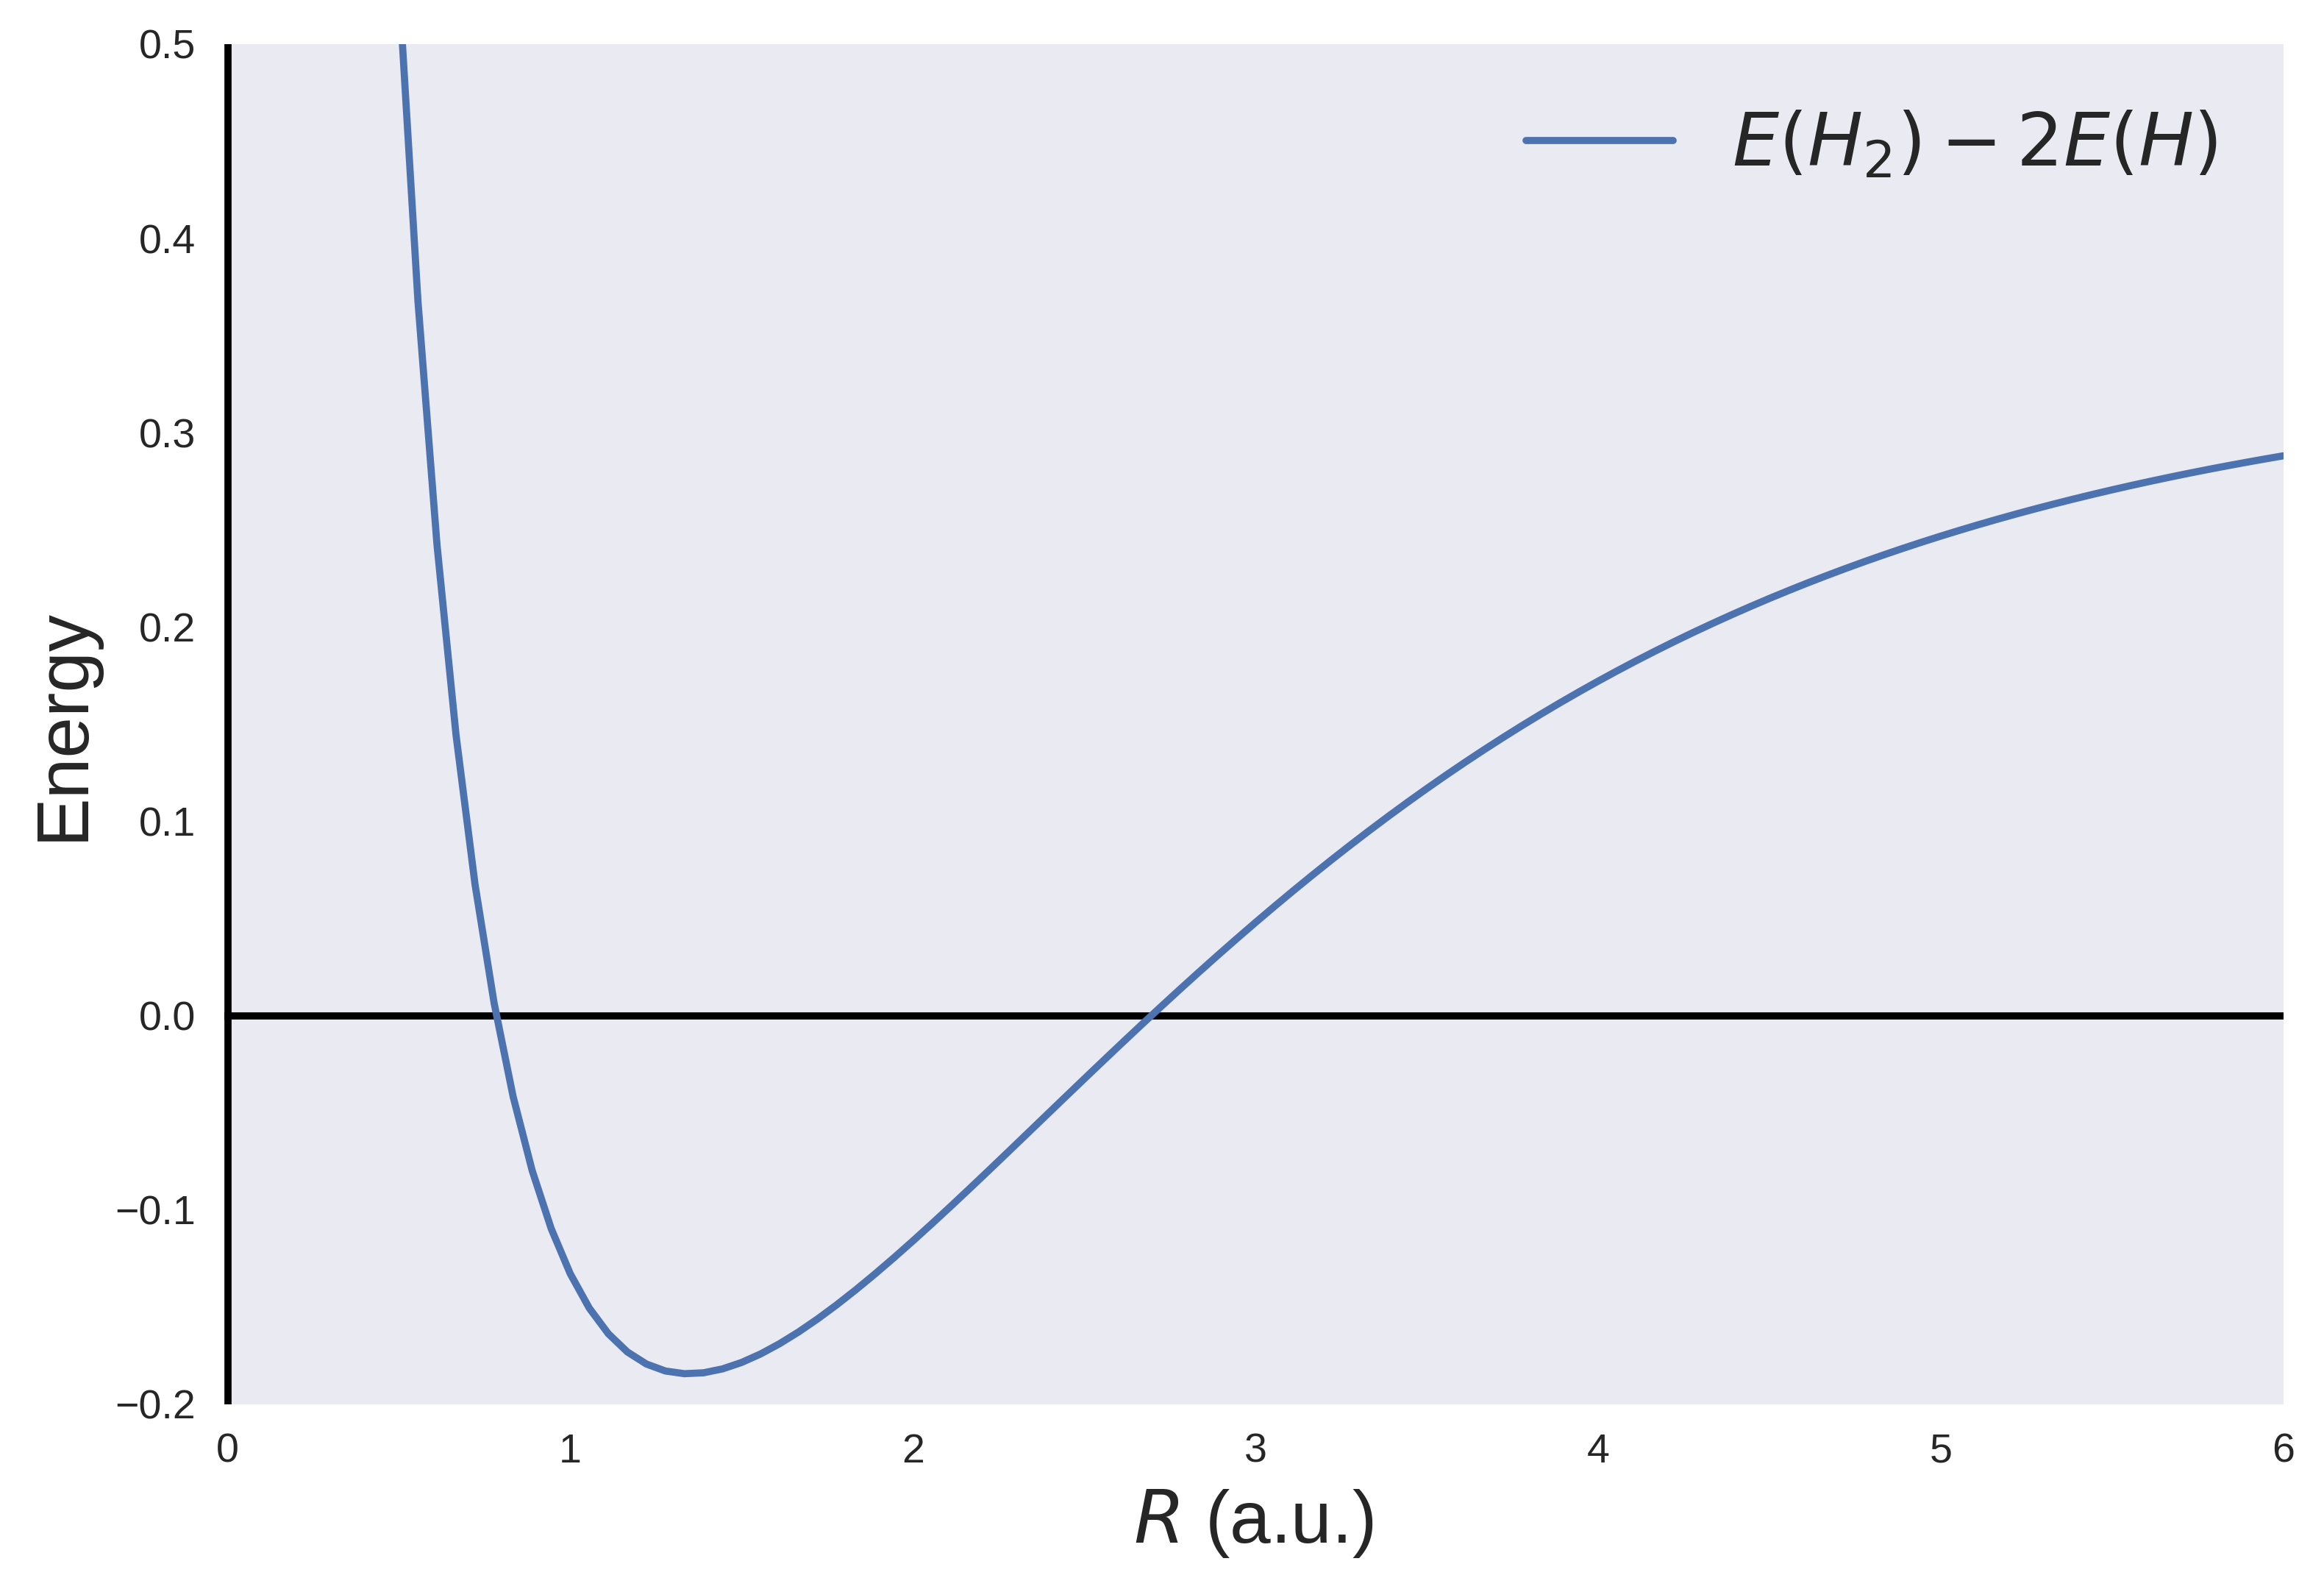

In [5]:
z = np.zeros(10)
x = np.linspace(-1, 6, 10)
y = np.linspace(-.2, .5, 10)
plt.figure(dpi=400)
plt.plot(distances, np.array(energy_vals) + 2*(.4666))
plt.plot(x, z, 'k', zorder=0)
plt.plot(z, y, 'k')
plt.xlabel(r'$R$ (a.u.)', fontsize=18)
plt.ylabel('Energy', fontsize=18)
plt.legend([r'$E(H_2) - 2E(H)$'], fontsize=18)
plt.grid(False)
plt.xlim(-.01, 6)
plt.ylim(-.2, .5)
plt.tight_layout()
plt.savefig('./figures/energy.png')
plt.show()